In [15]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers,models
import matplotlib.pyplot as plt

In [16]:
import tensorflow as tf
print(tf.__version__)


2.12.0


In [17]:
import os
os.getcwd()

img_size=256
batch_size=32
epochs=50
channels=3


In [18]:
dataset=tf.keras.preprocessing.image_dataset_from_directory(
    "plannt",shuffle=True,
    image_size=(img_size,img_size),
    batch_size=batch_size)

#api were we can simply acces the dataset

Found 9127 files belonging to 8 classes.


In [19]:
class_name=dataset.class_names
class_name
#folder name contain dataset were assumed as labels

['Pepper__bell___Bacterial_spot',
 'Pepper__bell___healthy',
 'Potato___Early_blight',
 'Potato___Late_blight',
 'Potato___healthy',
 'Tomato_Early_blight',
 'Tomato_Late_blight',
 'Tomato_healthy']

In [21]:
c_len=len(dataset)
c_len
#a batch contain 68*32=2152

286

In [22]:
#image exploration
for image_batch,label_image in dataset.take(1):#taking 1 batch
    print(image_batch.shape)#shows no of img,pxsize,rgb(32, 256, 256, 3)
    print(label_image.numpy())#0 to 2 labelled folder name based

(32, 256, 256, 3)
[1 1 1 7 3 2 0 5 6 6 7 1 2 2 6 7 6 0 1 2 6 3 1 5 0 2 3 1 4 0 3 2]


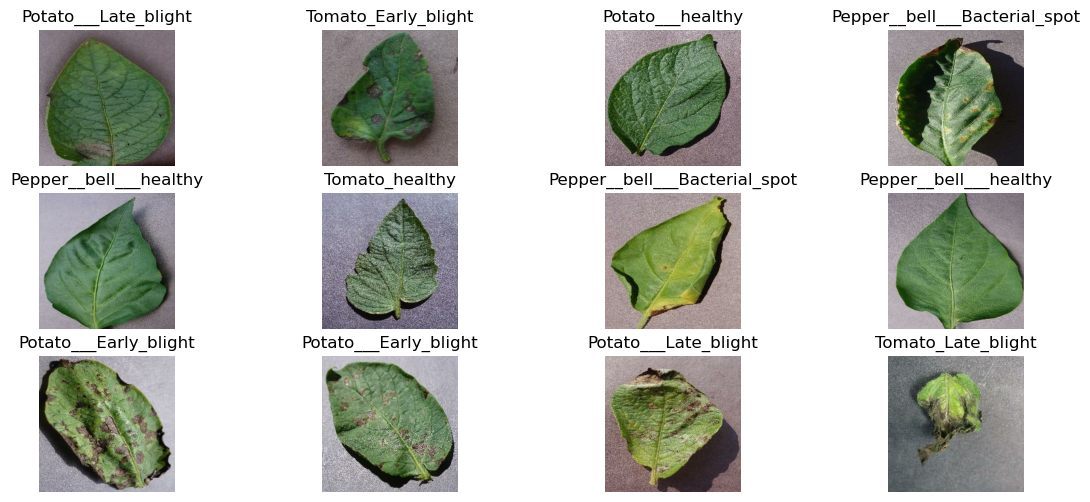

In [23]:

plt.figure(figsize=(14,6))#more image view in good shape
for image_batch,label_batch in dataset.take(1):
    for i in range(12):#
        ax=plt.subplot(3,4,i+1)#more image can see
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.axis("off")#remove of x,y axis
        plt.title(class_name[label_batch[i]])#add label to image
        

In [24]:
#split our dataset train,test split
#ds=dataset,size all setted by us
#skip used train not taken by val
def get_partion_tf(ds,train_split=0.8,val_split=0.1,test_split=0.1,shuffle=True,shuffle_size=10000):
        ds_size=len(ds)
        if shuffle:
            ds=ds.shuffle(shuffle_size,seed=12)
        
        train_size=int(train_split * ds_size)
        val_size=int(val_split * ds_size)
        test_size=int(test_split * ds_size)
        
        train_ds=ds.take(train_size)
        val_ds=ds.skip(train_size).take(val_size)
        test_ds=ds.skip(train_size).skip(val_size)
        
        return train_ds,val_ds,test_ds
    

In [25]:
train_ds, val_ds, test_ds=get_partion_tf(dataset)
#function calling dataset passing to the function and split train val test

#checking split in proper manner
tr=len(train_ds)
vr=len(val_ds)
tes=len(test_ds)
print(tr)
print(vr)
print(tes)

228
28
30


In [26]:
#caching is if we load a image from disk to memory same image
#loading it can be done by using cache memory so perfomance get higher

train_ds=train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds=val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds=test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [27]:
#resizing for more than 250px image testing model get ideal responce so we should resize the dataset for efficiency
resize_and_rescale=tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(img_size,img_size),
    layers.experimental.preprocessing.Rescaling(1.0/255)
                                       ])
#Sequential,Resizing,Rescaling must be capital in built call

In [28]:
#rotate and flip called data augmentation,based on image contract,saturation data must be augmented
data_augmentation=tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2),
])

In [30]:
#using CNN architecture calculate accuracy by test data and create a modelto send fast api server
#batch_size=32
#epochs=50
#channels=3
#n-classes=3
#print(image_size)#(256, 256)

input_shape = (batch_size,img_size,img_size,channels)
n_classes=8
model=models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32,(3,3),activation='relu',input_shape=input_shape),   
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,kernel_size=(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,kernel_size=(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64,activation='relu'),
    layers.Dense(n_classes,activation='softmax')
])

model.build(input_shape=input_shape)


In [15]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (32, 127, 127, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (32, 62, 62, 64)         0         
 2D)                                                  

In [31]:
#lossfuction matric
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [32]:
#train your network
#history we can see output epochs
history=model.fit(
    train_ds,
    
    epochs=epochs,
    batch_size=batch_size,
    verbose=1,#print output each epoches
    validation_data=val_ds
    
)

Epoch 1/50
228/228 [==============================] - 364s 2s/step - loss: 1.7313 - accuracy: 0.3294 - val_loss: 1.5470 - val_accuracy: 0.4788
Epoch 2/50
228/228 [==============================] - 402s 2s/step - loss: 0.9560 - accuracy: 0.6630 - val_loss: 0.7502 - val_accuracy: 0.7188
Epoch 3/50
228/228 [==============================] - 433s 2s/step - loss: 0.6565 - accuracy: 0.7607 - val_loss: 0.5881 - val_accuracy: 0.7690
Epoch 4/50
228/228 [==============================] - 386s 2s/step - loss: 0.5233 - accuracy: 0.8054 - val_loss: 0.5529 - val_accuracy: 0.7991
Epoch 5/50
228/228 [==============================] - 325s 1s/step - loss: 0.4434 - accuracy: 0.8391 - val_loss: 0.3925 - val_accuracy: 0.8415
Epoch 6/50
228/228 [==============================] - 336s 1s/step - loss: 0.3780 - accuracy: 0.8612 - val_loss: 0.3917 - val_accuracy: 0.8482
Epoch 7/50
228/228 [==============================] - 363s 2s/step - loss: 0.3545 - accuracy: 0.8678 - val_loss: 0.2854 - val_accuracy: 0.8996

In [33]:
scores=model.evaluate(test_ds)

30/30 [==============================] - 32s 305ms/step - loss: 0.0494 - accuracy: 0.9812


In [34]:
import numpy as np

first image predict
first image Actual Tomato_Late_blight
1/1 [==============================] - 1s 591ms/step
predict label: Tomato_Late_blight


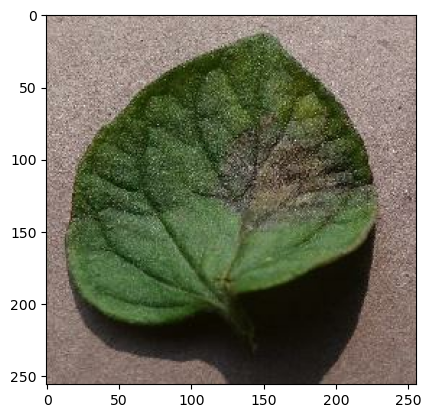

In [35]:
for images_batch,labels_batch in test_ds.take(1):
    first_image=images_batch[0].numpy().astype('uint8')
    first_label=labels_batch[0].numpy()
    print("first image predict")
    plt.imshow(first_image)
    print("first image Actual",class_name[first_label])
    batch_prediction=model.predict(images_batch)
    
print("predict label:",class_name[np.argmax(batch_prediction[0])])
    
    

In [51]:
def predict(model,img):
    img_array=tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array=tf.expand_dims(img_array,0)
    
    prediction=model.predict(img_array)
    predicted_class=class_name[np.argmax(prediction[0])]
    confidence=round(100*(np.max(prediction[0])),2)
       
    
    return predicted_class,confidence

In [1]:
plt.figure(figsize=(15,15))
for images,labels in test_ds.take(1):
    for i in range(9):
        ax=plt.subplot(3,3,i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        predicted_class,confidence=predict(model,images[i].numpy())
        if predicted_class=='Pepper__bell___Bacterial_spot':
            caption="aaa"
        elif  predicted_class== 'Pepper__bell___healthy':
            caption="bbb"
        elif  predicted_class== 'Potato___Early_blight':
            caption="ccc"
        elif  predicted_class== 'Potato___Late_blight':
            caption="ddd"
        elif  predicted_class== 'Potato___healthy':
            caption="eee"
        elif  predicted_class== 'Tomato_Early_blight':
            caption="fff"
        elif  predicted_class== 'Tomato_Late_blight':
            caption="ggg"
           
        elif  predicted_class== 'Tomato_healthy':
            caption="hhh" 
        actual_class=class_name[labels[i]]
        plt.title(f"Actual:{actual_class}\n Predicted:{predicted_class}\nConfidece{confidence}\ncaption:{caption}")
        plt.axis("off")

NameError: name 'plt' is not defined

In [54]:
model_version=1
model.save(f"../models/{model_version}")

INFO:tensorflow:Assets written to: ../models/1\assets


INFO:tensorflow:Assets written to: ../models/1\assets
